## 1) Libraries Installation
##### The cell below is to help you keep track the libraries used and install them quickly.
##### Ensure the correct library names are used, and follow the syntax: **%pip install PACKAGE_NAME**.

In [ ]:
# %pip install pandas
# %pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should follow the format %pip install PACKAGE_NAME

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ardl_select_order

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

## 2) Main Section for Code
### **ALL code for machine learning and dataset analysis** should be entered below.
##### Ensure that your code is clear and readable.
##### Remember to include comments and markdown notes as necessary to explain and highlight important segments of your code.

## 2.0 Exploratory Data Analysis

In [ ]:
# Summary Statistics
quarterly_data = pd.read_csv("Quarterly Data.csv")
df = quarterly_data[['sasdate', 'GDPC1', 'PCECC96', 'GPDIC1', 'GCEC1', 'EXPGSC1', 'IMPGSC1']]
df.rename(columns={'GDPC1': 'Real GDP', 'PCECC96': 'Consumption', 'GPDIC1': 'Investment',
                   'GCEC1': 'Gvt Spending','EXPGSC1': 'Exports', 'IMPGSC1': 'Imports'}, inplace=True)
print(df.describe())

           Real GDP   Consumption   Investment  Gvt Spending      Exports  \
count    265.000000    265.000000   265.000000    265.000000   265.000000   
mean   11360.216083   7445.130234  1748.850125   2477.557649   999.655955   
std     5841.690279   4094.139063  1147.695930    834.100894   833.280039   
min        0.000000      0.000000     0.000000      0.000000     1.000000   
25%     6111.751000   3792.426000   765.742000   1717.716000   272.020000   
50%    10090.569000   6410.312000  1301.412000   2559.584000   718.914000   
75%    16561.866000  11158.801000  2638.672000   3273.905000  1714.981000   
max    23400.294000  16113.035000  4377.736000   3966.247000  2638.199000   

           Imports  
count   265.000000  
mean   1254.733026  
std    1088.348775  
min       1.000000  
25%     301.679000  
50%     718.810000  
75%    2311.934000  
max    3707.429000  


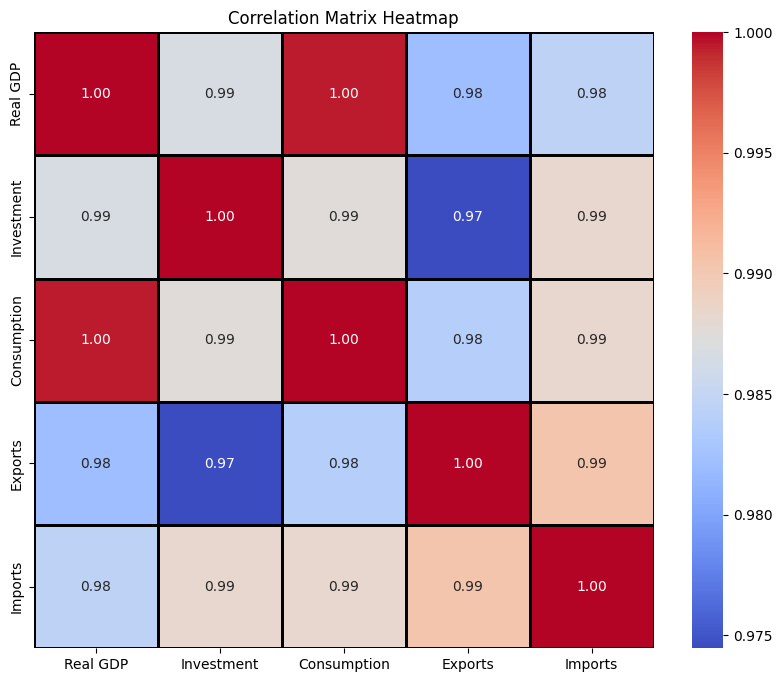

In [ ]:
# Correlation matrix heatmap
corr_matrix = df[['Real GDP', 'Investment', 'Consumption', 'Exports', 'Imports']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=1, linecolor='black')
plt.title('Correlation Matrix Heatmap')
plt.show()

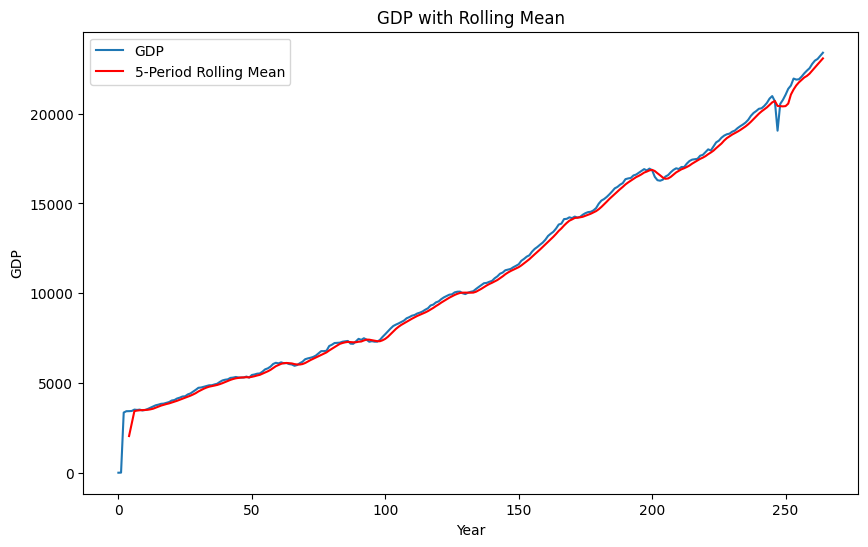

In [ ]:
# Rolling average shows the trend of Real GDP overtime
# Calculate rolling mean (5-period moving average, adjust window size as needed)
df['GDP_rolling_mean'] = df['Real GDP'].rolling(window=5).mean()

# Plot the original data and the rolling mean
plt.figure(figsize=(10, 6))
plt.plot(df['Real GDP'], label='GDP')
plt.plot(df['GDP_rolling_mean'], label='5-Period Rolling Mean', color='red')
plt.legend()
plt.title('GDP with Rolling Mean')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.show()

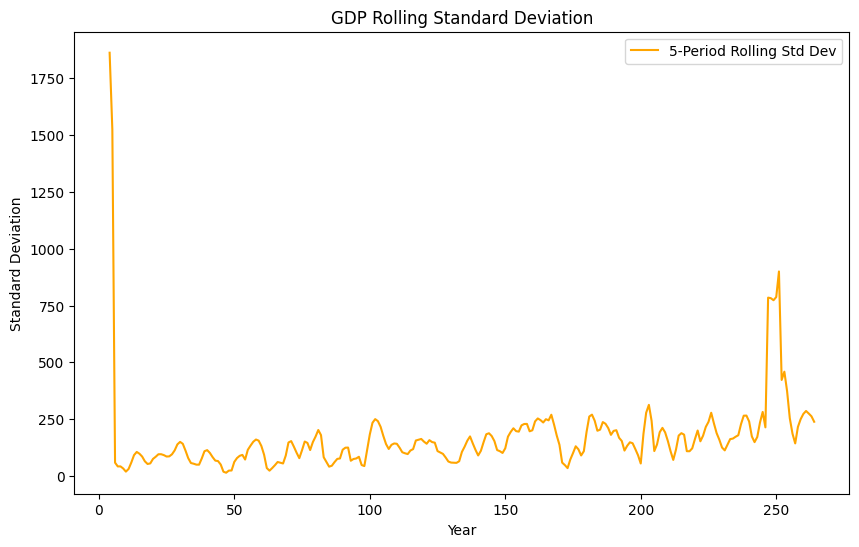

In [ ]:
# Rolling standard deviation shows the volatlilty of Real GDP
df['GDP_rolling_std'] = df['Real GDP'].rolling(window=5).std()

# Plot the rolling standard deviation
plt.figure(figsize=(10, 6))
plt.plot(df['GDP_rolling_std'], label='5-Period Rolling Std Dev', color='orange')
plt.title('GDP Rolling Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

## 2.1 Select necessary variables
PCECC96 - Real Personal Consumption Expenditures (Billions of Chained 2017 Dollars)

GPDIC1 - Real Gross Private Domestic Investment, 3 decimal (Billions of Chained 2017 Dollars)

GCEC1 - Real Government Consumption Expenditures & Gross Investment (Billions of Chained 2017 Dollars)

EXPGSC1 - Real Exports of Goods & Services, 3 Decimal (Billions of Chained 2017 Dollars)

IMPGSC1 - Real Imports of Goods & Services, 3 Decimal (Billions of Chained 2017 Dollars)



In [ ]:
quarterly_data = pd.read_csv("Quarterly Data.csv")
quarterly_data = quarterly_data.iloc[2:]

# Include variables for extended model
df = quarterly_data[['sasdate', 'GDPC1', 'PCECC96', 'GPDIC1', 'GCEC1', 'EXPGSC1', 'IMPGSC1']]

# Convert sasdate to quarters
def rows_to_quarter(df):
    df['sasdate'] = pd.to_datetime(df['sasdate'], format='%m/%d/%Y')
    df['year'] = df['sasdate'].dt.year
    df['month'] = df['sasdate'].dt.month

    def get_quarter(month):
        if month in [1, 2, 3]:
            return 'Q1'
        elif month in [4, 5, 6]:
            return 'Q2'
        elif month in [7, 8, 9]:
            return 'Q3'
        elif month in [10, 11, 12]:
            return 'Q4'

    df['quarter'] = df['month'].apply(get_quarter)
    df['time_quarter'] = df['year'].astype(str) + ':' + df['quarter']
    df.drop(columns=['year', 'month', 'quarter'], inplace=True)
    return df
df = rows_to_quarter(df)

# Log the GDP column to prepare for stationarity transformation
df['log_gdp'] = np.log(df['GDPC1'])
df['sasdate'] = pd.to_datetime(df['sasdate'], format='%m/%d/%Y')
df.rename(columns={'GDPC1': 'Real GDP', 'PCECC96': 'Consumption', 'GPDIC1': 'Investment',
                   'GCEC1': 'Gvt Spending','EXPGSC1': 'Exports', 'IMPGSC1': 'Imports'}, inplace=True)
df.set_index('sasdate', inplace=True)
print(df.head)

<bound method NDFrame.head of              Real GDP  Consumption  Investment  Gvt Spending   Exports  \
sasdate                                                                  
1959-03-01   3352.129     2039.017     354.894      1142.671    89.697   
1959-06-01   3427.667     2070.508     382.500      1156.740    88.981   
1959-09-01   3430.057     2092.138     357.798      1166.589    97.562   
1959-12-01   3439.832     2094.495     369.442      1157.052    92.734   
1960-03-01   3517.181     2114.532     406.581      1137.363   104.686   
...               ...          ...         ...           ...       ...   
2023-09-01  22780.933    15646.695    4237.303      3836.304  2521.467   
2023-12-01  22960.600    15781.367    4244.835      3870.720  2559.591   
2024-03-01  23053.545    15856.867    4282.515      3887.718  2571.763   
2024-06-01  23223.906    15967.266    4369.185      3917.049  2578.386   
2024-09-01  23400.294    16113.035    4377.736      3966.247  2638.199   

       

## 2.2 Visualize time series data

- There are common trends across GDP and variables, as seen from dips in 2008, 2020.

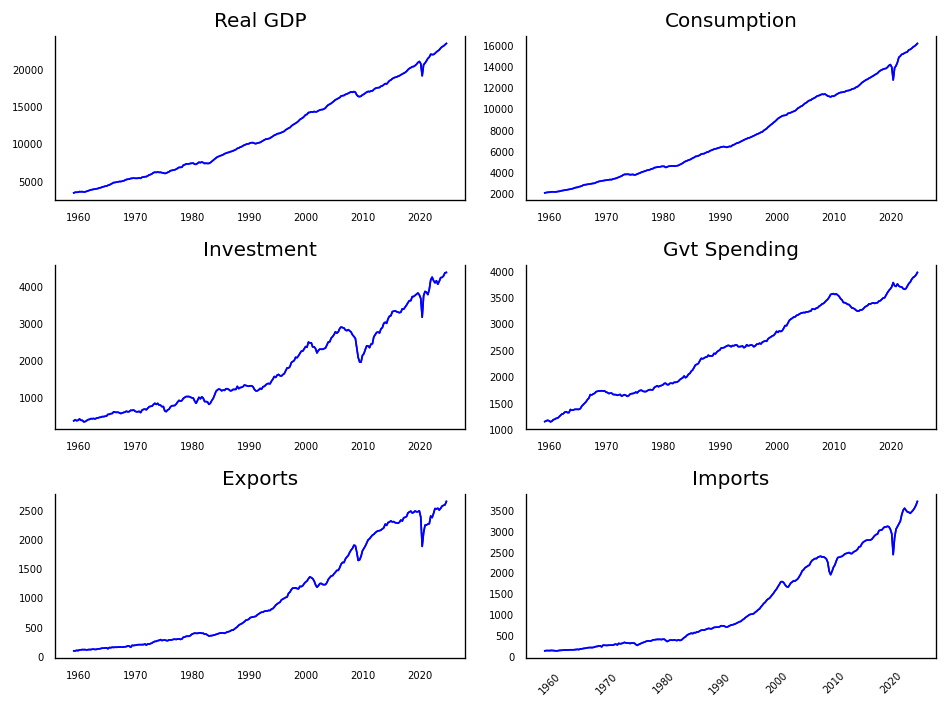

In [ ]:
# Visualise time series data
fig,axes=plt.subplots(nrows=3,ncols=2,dpi=120,figsize=(8,6))
for i,ax in enumerate(axes.flatten()):
      data=df[df.columns[i]]
      ax.plot(data, color='blue', linewidth=1)
      ax.plot(df.index, data, color='blue', linewidth=1)
      ax.set_title(df.columns[i])
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
      plt.xticks(rotation=45)
plt.tight_layout();

## 2.3 Obtain quarterly and annualised growth rate from GDP
- stationarity transformation of Real GDP to annualised GDP growth

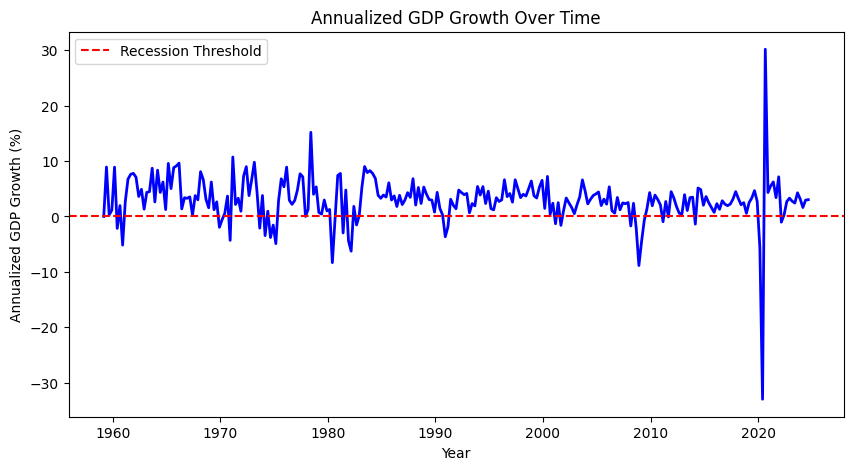

            Real GDP  Consumption  Investment  Gvt Spending  Exports  Imports  \
sasdate                                                                         
1959-03-01  3352.129     2039.017     354.894      1142.671   89.697  115.440   
1959-06-01  3427.667     2070.508     382.500      1156.740   88.981  121.057   
1959-09-01  3430.057     2092.138     357.798      1166.589   97.562  122.212   
1959-12-01  3439.832     2094.495     369.442      1157.052   92.734  119.109   
1960-03-01  3517.181     2114.532     406.581      1137.363  104.686  123.608   

           time_quarter   log_gdp  quarterly_growth  annualized_growth  
sasdate                                                                 
1959-03-01      1959:Q1  8.117351          0.000000           0.000000  
1959-06-01      1959:Q2  8.139635          0.022284           8.913675  
1959-09-01      1959:Q3  8.140332          0.000697           0.278810  
1959-12-01      1959:Q4  8.143178          0.002846           1.138

In [ ]:
# Quarterly and annualised growth rate
df['quarterly_growth'] = df['log_gdp'].diff()
df['annualized_growth'] = df['quarterly_growth'] * 4 * 100
df['annualized_growth'] = df['annualized_growth'].fillna(0)
df['quarterly_growth'] = df['quarterly_growth'].fillna(0)

# Visualize annualised growth rate
plt.figure(figsize=(10,5))
plt.plot(df.index, df['annualized_growth'], color='blue', linewidth=2)
plt.axhline(y=0, color='red', linestyle='--', label="Recession Threshold")
plt.xlabel('Year')
plt.ylabel('Annualized GDP Growth (%)')
plt.title('Annualized GDP Growth Over Time')
plt.legend()
plt.show()

print(df.head())

## 2.4 Convert series of variables to stationary
- All the series of variables are stationary after taking the first difference

In [ ]:
# Code to test for stationarity of annualised growth rate
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("The series is likely non-stationary.")
    else:
        print("The series is likely stationary.")

# Ensure series variables are stationary
## Originally, all the series of variables are non-stationary

# First round of differencing
df['Investment'] = df['Investment'].diff()
df['Consumption'] = df['Consumption'].diff()
df['Gvt Spending'] = df['Gvt Spending'].diff()
df['Exports'] = df['Exports'].diff()
df['Imports'] = df['Imports'].diff()
df.fillna(0, inplace=True)

adf_test(df['Investment'])
adf_test(df['Gvt Spending'])
adf_test(df['Consumption'])
adf_test(df['Exports'])
adf_test(df['Imports'])

ADF Statistic: -15.324926825978041
p-value: 4.017403977048492e-28
The series is likely stationary.
ADF Statistic: -4.42973327974723
p-value: 0.00026286059002462477
The series is likely stationary.
ADF Statistic: -18.326231217752827
p-value: 2.260587700071692e-30
The series is likely stationary.
ADF Statistic: -12.692384111381871
p-value: 1.1248464740182629e-23
The series is likely stationary.
ADF Statistic: -13.912651449399423
p-value: 5.474690775245617e-26
The series is likely stationary.


## 2.5 Determine number of lags for AR model
- AR(8) has the lowest BIC value of 1511.28

In [ ]:
def select_best_lag(time_series, max_lag):
    bic_values = []
    for p in range(1, max_lag + 1):
        model = AutoReg(time_series, lags = p)
        model_fit = model.fit()
        bic_values.append((p, model_fit.bic))
    return bic_values

# Set max_lag to try and get the best lag based on AIC
max_lag = 10
aic_scores = select_best_lag(df['annualized_growth'], max_lag)

# Print the AIC values for different lags
for lag, bic in aic_scores:
    print(f'Lag: {lag}, BIC: {bic}')

# Find the lag with the minimum AIC value
best_lag = min(aic_scores, key=lambda x: x[1])[0]
print(f'\nOptimal Lag based on AIC: {best_lag}')

Lag: 1, BIC: 1518.6679302937519
Lag: 2, BIC: 1515.0062983883336
Lag: 3, BIC: 1515.2289079071552
Lag: 4, BIC: 1515.7147751864982
Lag: 5, BIC: 1514.4057275618184
Lag: 6, BIC: 1513.275202629124
Lag: 7, BIC: 1513.7656957117931
Lag: 8, BIC: 1511.281154160078
Lag: 9, BIC: 1511.9082358234164
Lag: 10, BIC: 1511.287258589239

Optimal Lag based on AIC: 8


## 2.7 Forecast annualized GDP growth with optimum lag

In [ ]:
def forecast_ar_model(df, target_variable='annualized_growth', forecast_horizon=4):
    y = df[target_variable]
    model = AutoReg(y, lags=8)
    model_fit = model.fit()
    forecast = model_fit.predict(start=len(y), end=len(y) + forecast_horizon - 1)
    return forecast, model

forecast_ar_model(df, target_variable='annualized_growth', forecast_horizon=5)

(2024-12-01    2.978632
 2025-03-01    2.941140
 2025-06-01    2.952806
 2025-09-01    3.040201
 2025-12-01    3.040145
 Freq: QS-DEC, dtype: float64,
 <statsmodels.tsa.ar_model.AutoReg at 0x7ec025b58890>)

## 2.8 ADL Model

In [ ]:
# Define the dependent and independent variables
dependent_var = df['annualized_growth']
independent_vars = df[['Investment', 'Consumption', 'Gvt Spending', 'Exports', 'Imports']]

# Select optimal lags based on AIC
optimal_lags = ardl_select_order(dependent_var, exog=independent_vars, maxlag=10, maxorder=3, ic='aic')

print(f"Optimal lags for dependent variable (annualized_growth): {optimal_lags.ar_lags}")

selected_model = optimal_lags.model

print(f"Optimal lags for exogenous variables: {selected_model.ardl_order[1:]}")

#Fit the ARDL model with optimal lags
# Use the selected model and its ardl_order for fitting
ardl_res = selected_model.fit()

print(ardl_res.summary())
# Forecast the next 4 quarters
forecast_steps = 4

def forecast_exogs_1 (df, target_variable='Investment', forecast_horizon=4):
    y = df[target_variable]
    model = AutoReg(y, lags=2)
    model_fit = model.fit()
    forecast = model_fit.predict(start=len(y), end=len(y) + forecast_horizon - 1)
    return forecast

future_invest = forecast_exogs_1(df, target_variable='Investment', forecast_horizon=5)
future_consump = forecast_exogs_1(df, target_variable='Consumption', forecast_horizon=5)
future_gvtspend = forecast_exogs_1(df, target_variable='Gvt Spending', forecast_horizon=5)

def forecast_exogs_2 (df, target_variable='Exports', forecast_horizon=4):
    y = df[target_variable]
    model = AutoReg(y, lags=1)
    model_fit = model.fit()
    forecast = model_fit.predict(start=len(y), end=len(y) + forecast_horizon - 1)
    return forecast

future_exp = forecast_exogs_2(df, target_variable='Exports', forecast_horizon=5)
future_imp = forecast_exogs_2(df, target_variable='Imports', forecast_horizon=5)

index = future_invest.index

future_exog = pd.DataFrame({
    'Investment': future_invest.values,  # Use .values to get the underlying array
    'Consumption': future_consump.values,
    'Gvt Spending': future_gvtspend.values,
    'Exports': future_exp.values,
    'Imports': future_imp.values
}, index=index)

print(future_exog)

forecast = ardl_res.forecast(steps=forecast_steps, exog=future_exog)
forecast


Optimal lags for dependent variable (annualized_growth): [1, 2]
Optimal lags for exogenous variables: (2, 2, 2, 1, 1)
                                ARDL Model Results                                
Dep. Variable:          annualized_growth   No. Observations:                  263
Model:             ARDL(2, 2, 2, 2, 1, 1)   Log Likelihood                -524.757
Method:                   Conditional MLE   S.D. of innovations              1.807
Date:                    Tue, 11 Feb 2025   AIC                           1083.515
Time:                            17:17:20   BIC                           1144.112
Sample:                        09-01-1959   HQIC                          1107.873
                             - 09-01-2024                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4456      0.2

,0
2024-12-01,1.418478
2025-03-01,2.105862
2025-06-01,2.272287
2025-09-01,2.455789


## 2.9 Model evaluation using RMSE

In [ ]:
# Split into test and training data
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define AR(8) model and ADL model
model = sm.tsa.AutoReg(train['annualized_growth'], lags=10).fit()

# Forecast of test data
predictions = model.predict(start=len(train), end=len(df) - 1, dynamic=False)
adl_model_predictions = ardl_res.forecast(steps=len(test), exog = df[['Investment', 'Consumption', 'Gvt Spending', 'Exports', 'Imports']].tail(len(test)))

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test['annualized_growth'], predictions))
rmse_adl = np.sqrt(mean_squared_error(test['annualized_growth'], adl_model_predictions))
print(f'RMSE_AR: {rmse:.4f}')
print(f'RMSE_ADL: {rmse_adl:.4f}')

RMSE_AR: 6.5202
RMSE_ADL: 2.1270
